# 时序异常检测基准测试框架

这个notebook是整个基准测试框架的核心运行脚本，用于:
- 加载和管理实验配置
- 数据集处理（未完成）
- 执行完整的模型训练和评估流程
- 生成结果报告和可视化（待添加新评估图像和指标）


In [1]:
# 导入依赖库
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')





In [2]:
# 添加项目路径
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"项目根目录: {project_root}")
print("依赖库导入完成")

# 分步导入框架组件
try:
    from src.config_manager import ConfigManager
    print("ConfigManager 导入成功-error")
except ImportError as e:
    # print(f"ConfigManager 导入失败: {e}")
    print("start")

try:
    from src.config_manager import ConfigManager
    print("ConfigManager 导入成功")
except ImportError as e:
    print(f"ConfigManager 导入失败: {e}")

try:
    from src.dataloaders import DataPipeline
    print("DataPipeline 导入成功")
except ImportError as e:
    print(f"DataPipeline 导入失败: {e}")

try:
    from src.models.base_model import ModelFactory
    print("ModelFactory 导入成功")
except ImportError as e:
    print(f"ModelFactory 导入失败: {e}")

try:
    from src.trainer import Trainer
    print("Trainer 导入成功")
except ImportError as e:
    print(f"Trainer 导入失败: {e}")

try:
    from src.metrics import TimeSeriesEvaluator, print_evaluation_report
    print("Metrics 导入成功")
except ImportError as e:
    print(f"Metrics 导入失败: {e}")



# 设置随机种子
import random
random.seed(42)
np.random.seed(42)

print("导入检测完成")

INFO:src.models.base_model:注册模型: isolation_forest
INFO:src.models.base_model:注册模型: iforest


项目根目录: /home/chen/dev/fault_diagnosis_lib/benchmark
依赖库导入完成


INFO:src.models.base_model:注册模型: lstm_autoencoder
INFO:src.models.base_model:注册模型: lstm_ae


start
ConfigManager 导入成功
DataPipeline 导入成功
ModelFactory 导入成功
Trainer 导入成功
Metrics 导入成功
导入检测完成


## 1. 配置管理与实验设置

In [3]:
# # 创建配置管理器
# # from src.config_manager import ConfigManager
# config_manager = ConfigManager()

# # 定义默认实验配置
# default_config = {
#     'experiment': {
#         'name': 'benchmark_experiment_01',
#         'description': '时序异常检测基准测试实验',
#         'version': '1.0',
#         'author': 'Benchmark Team',
#         'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#     },
#     'data': {
#         'dataset': 'swat',
#         'train_file': '../data/raw/swat_train.csv',
#         'test_file': '../data/raw/swat_test.csv',
#         'preprocessing': {
#             'normalize': True,
#             'fill_missing': True,
#             'remove_outliers': False
#         },
#         'window_size': 10,
#         'stride': 1
#     },
#     'models': {
#         'iforest': {
#             'n_estimators': 100,
#             'contamination': 0.1,
#             'random_state': 42
#         },
#         'lstm_ae': {
#             'hidden_dim': 64,
#             'num_layers': 2,
#             'dropout': 0.2,
#             'lr': 0.001,
#             'batch_size': 32,
#             'epochs': 50,
#             'patience': 10
#         }
#     },
#     'evaluation': {
#         'metrics': ['f1', 'precision', 'recall', 'auc', 'f1_point_adjusted'],
#         'tolerance': 0,
#         'auto_threshold': True
#     },
#     'output': {
#         'save_results': True,
#         'save_models': False,
#         'generate_plots': True,
#         'results_dir': '../results'
#     }
# }

# # 保存默认配置
# config_path = project_root / 'configs' / 'default_experiment.yaml'
# config_manager.save_config(default_config, config_path)

# print("默认配置已保存")
# print(f"配置文件: {config_path}")

In [4]:
# 加载用户的实验配置
# config_file = project_root / 'configs' / 'default_experiment.yaml'
config_file = "/home/chen/dev/fault_diagnosis_lib/benchmark/configs/default_experiment.yaml"
config_manager = ConfigManager(config_dir = config_file)
config = config_manager.load_config()

print("实验配置:")
print(f"   - 实验名称: {config['experiment']['name']}")
print(f"   - 数据集: {config['data']['dataset']}")
print(f"   - 模型: {list(config['models'].keys())}")
print(f"   - 评估指标: {config['evaluation']['metrics']}")

INFO:src.config_manager:配置管理器初始化完成，配置目录: /home/chen/dev/fault_diagnosis_lib/benchmark/configs/default_experiment.yaml
INFO:src.config_manager:配置文件加载成功: /home/chen/dev/fault_diagnosis_lib/benchmark/configs/default_experiment.yaml
INFO:src.config_manager:配置验证通过


实验配置:
   - 实验名称: benchmark_experiment_01
   - 数据集: swat
   - 模型: ['iforest', 'lstm_ae']
   - 评估指标: ['f1', 'precision', 'recall', 'auc', 'f1_point_adjusted']


## 2. 数据加载与预处理

In [5]:
# 创建数据管道
data_pipeline = DataPipeline(config)

# 加载数据
dataset_name = config['data']['dataset']
print(f"加载数据集: {dataset_name}")

try:
    # 尝试加载真实数据
    train_data, train_labels, test_data, test_labels, metadata = data_pipeline.load_dataset(
        dataset_name, 
        config['data']
    )
    print("数据加载成功")
    
except Exception as e:
    print(f"真实数据加载失败: {e}")
    print("使用模拟数据进行演示")
    
    # 生成模拟数据
    from src.dataloaders import DataMetadata
    
    # 创建模拟数据
    n_samples = 1000
    n_features = 10
    
    # 训练数据（大部分正常）
    train_data = np.random.randn(n_samples, n_features)
    train_labels = np.zeros(n_samples)
    
    # 测试数据（包含异常）
    test_data = np.random.randn(n_samples, n_features)
    test_labels = np.zeros(n_samples)
    
    # 注入异常
    anomaly_indices = np.random.choice(n_samples, size=int(0.1 * n_samples), replace=False)
    test_data[anomaly_indices] += 3  # 异常数据偏移
    test_labels[anomaly_indices] = 1
    # 创建元数据（使用正确的参数）
    metadata = DataMetadata(
        dataset_name="simulated_data",
        label_granularity="point-wise",
        fault_type="binary", 
        num_classes=2,
        sequence_length=n_samples,
        feature_dim=n_features,
    )

print(f"数据统计:")
print(f"   - 训练集: {train_data.shape}")
print(f"   - 测试集: {test_data.shape}")
print(f"   - 特征数: {metadata.feature_dim}")
print(f"   - 故障类型: {metadata.fault_type}")

加载数据集: swat
真实数据加载失败: 'DataPipeline' object has no attribute 'load_dataset'
使用模拟数据进行演示
数据统计:
   - 训练集: (1000, 10)
   - 测试集: (1000, 10)
   - 特征数: 10
   - 故障类型: binary


## 3. 模型训练与评估

In [6]:
# 初始化结果存储
experiment_results = {}
model_objects = {}

# 创建评估器
evaluator = TimeSeriesEvaluator(tolerance=config['evaluation']['tolerance'])

print("开始模型训练与评估")
print("=" * 60)

开始模型训练与评估


In [7]:
# 训练和评估 Isolation Forest
if 'iforest' in config['models']:
    print("\\nIsolation Forest")
    print("-" * 40)
    
    # 创建模型
    iforest_config = config['models']['iforest']
    model = ModelFactory.create_model('iforest', iforest_config)
    
    # 训练
    print("训练模型...")
    model.fit(train_data, metadata)
    
    # 预测 - 使用anomaly_scores而不是binary predictions
    print("生成预测...")
    anomaly_scores = model.predict_anomaly_score(test_data)
    
    # 评估
    print("评估性能...")
    results = evaluator.evaluate(test_labels, anomaly_scores, metadata)
    
    # 存储结果
    experiment_results['iforest'] = results
    model_objects['iforest'] = model
    
    # 显示结果
    print_evaluation_report(results, "Isolation Forest 评估结果")

INFO:src.models.base_model:初始化模型: IsolationForest
INFO:src.models.iforest:IsolationForest配置: {'contamination': 0.1, 'n_estimators': 100, 'max_samples': 'auto', 'max_features': 1.0, 'bootstrap': False, 'random_state': 42, 'n_jobs': -1, 'normalize': True}
INFO:src.models.iforest:Isolation Forest模型构建完成，输入形状: (1000, 10)
INFO:src.models.iforest:数据标准化器已拟合
INFO:src.models.iforest:开始训练Isolation Forest...
INFO:src.models.iforest:Isolation Forest训练完成
INFO:src.metrics:开始评估，数据类型: binary, 标签粒度: point-wise


\nIsolation Forest
----------------------------------------
训练模型...
生成预测...
评估性能...

📊 Isolation Forest 评估结果
📈 基础指标:
   - accuracy: 0.9990
   - precision: 1.0000
   - recall: 0.9900
   - f1: 0.9950
   - auc: 1.0000

🎯 Point-Adjusted指标:
   - f1_point_adjusted: 0.9944
   - precision_pa: 1.0000
   - recall_pa: 0.9889

⏰ 时序指标:
   - detection_delay: 0.0000
   - early_detection_rate: 0.9889

🎚️  最佳阈值: 0.1614


In [8]:
# 训练和评估 LSTM AutoEncoder
if 'lstm_ae' in config['models']:
    print("\nLSTM AutoEncoder")
    print("-" * 40)
    
    try:
        # 创建模型
        lstm_config = config['models']['lstm_ae']
        model = ModelFactory.create_model('lstm_ae', lstm_config)
        
        # 训练
        print("训练模型...")
        model.fit(train_data, metadata)
        
        # 预测
        print("生成预测...")
        anomaly_scores = model.predict(test_data, metadata)
        
        # 评估
        print("评估性能...")
        results = evaluator.evaluate(test_labels, anomaly_scores, metadata)
        
        # 存储结果
        experiment_results['lstm_ae'] = results
        model_objects['lstm_ae'] = model
        
        # 显示结果
        print_evaluation_report(results, "LSTM AutoEncoder 评估结果")
        
    except Exception as e:
        print(f"LSTM AutoEncoder 训练失败: {e}")
        print("   这可能是由于缺少PyTorch依赖或其他环境问题")

INFO:src.models.base_model:初始化模型: LSTM_AutoEncoder



LSTM AutoEncoder
----------------------------------------


INFO:src.models.lstm_ae:使用设备: cuda
INFO:src.models.lstm_ae:LSTM AutoEncoder配置: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.2, 'bidirectional': False, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'patience': 10, 'normalize': True, 'sequence_length': 50, 'device': 'auto', 'lr': 0.001}


训练模型...


INFO:src.models.lstm_ae:LSTM AutoEncoder模型构建完成
INFO:src.models.lstm_ae:模型参数数量: 119946
INFO:src.models.lstm_ae:数据标准化器已拟合


LSTM AutoEncoder 训练失败: 'DataMetadata' object has no attribute 'reshape'
   这可能是由于缺少PyTorch依赖或其他环境问题


## 4. 结果对比与可视化

In [9]:
# 结果汇总对比
if experiment_results:
    print("\n模型性能对比")
    print("=" * 80)
    
    # 创建对比表格
    comparison_metrics = ['f1', 'precision', 'recall', 'auc', 'f1_point_adjusted']
    comparison_data = []
    
    for model_name, results in experiment_results.items():
        row = {'模型': model_name}
        for metric in comparison_metrics:
            if metric in results:
                value = results[metric]
                if isinstance(value, float) and not np.isnan(value):
                    row[metric] = f"{value:.4f}"
                else:
                    row[metric] = "N/A"
            else:
                row[metric] = "N/A"
        comparison_data.append(row)
    
    # 显示对比表格
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # 找出最佳模型
    best_model = None
    best_f1 = -1
    
    for model_name, results in experiment_results.items():
        if 'f1' in results and not np.isnan(results['f1']):
            if results['f1'] > best_f1:
                best_f1 = results['f1']
                best_model = model_name
    
    if best_model:
        print(f"\n最佳模型: {best_model} (F1 Score: {best_f1:.4f})")
else:
    print("没有成功的实验结果")


模型性能对比
     模型     f1 precision recall    auc f1_point_adjusted
iforest 0.9950    1.0000 0.9900 1.0000            0.9944

最佳模型: iforest (F1 Score: 0.9950)



Generating visualization charts


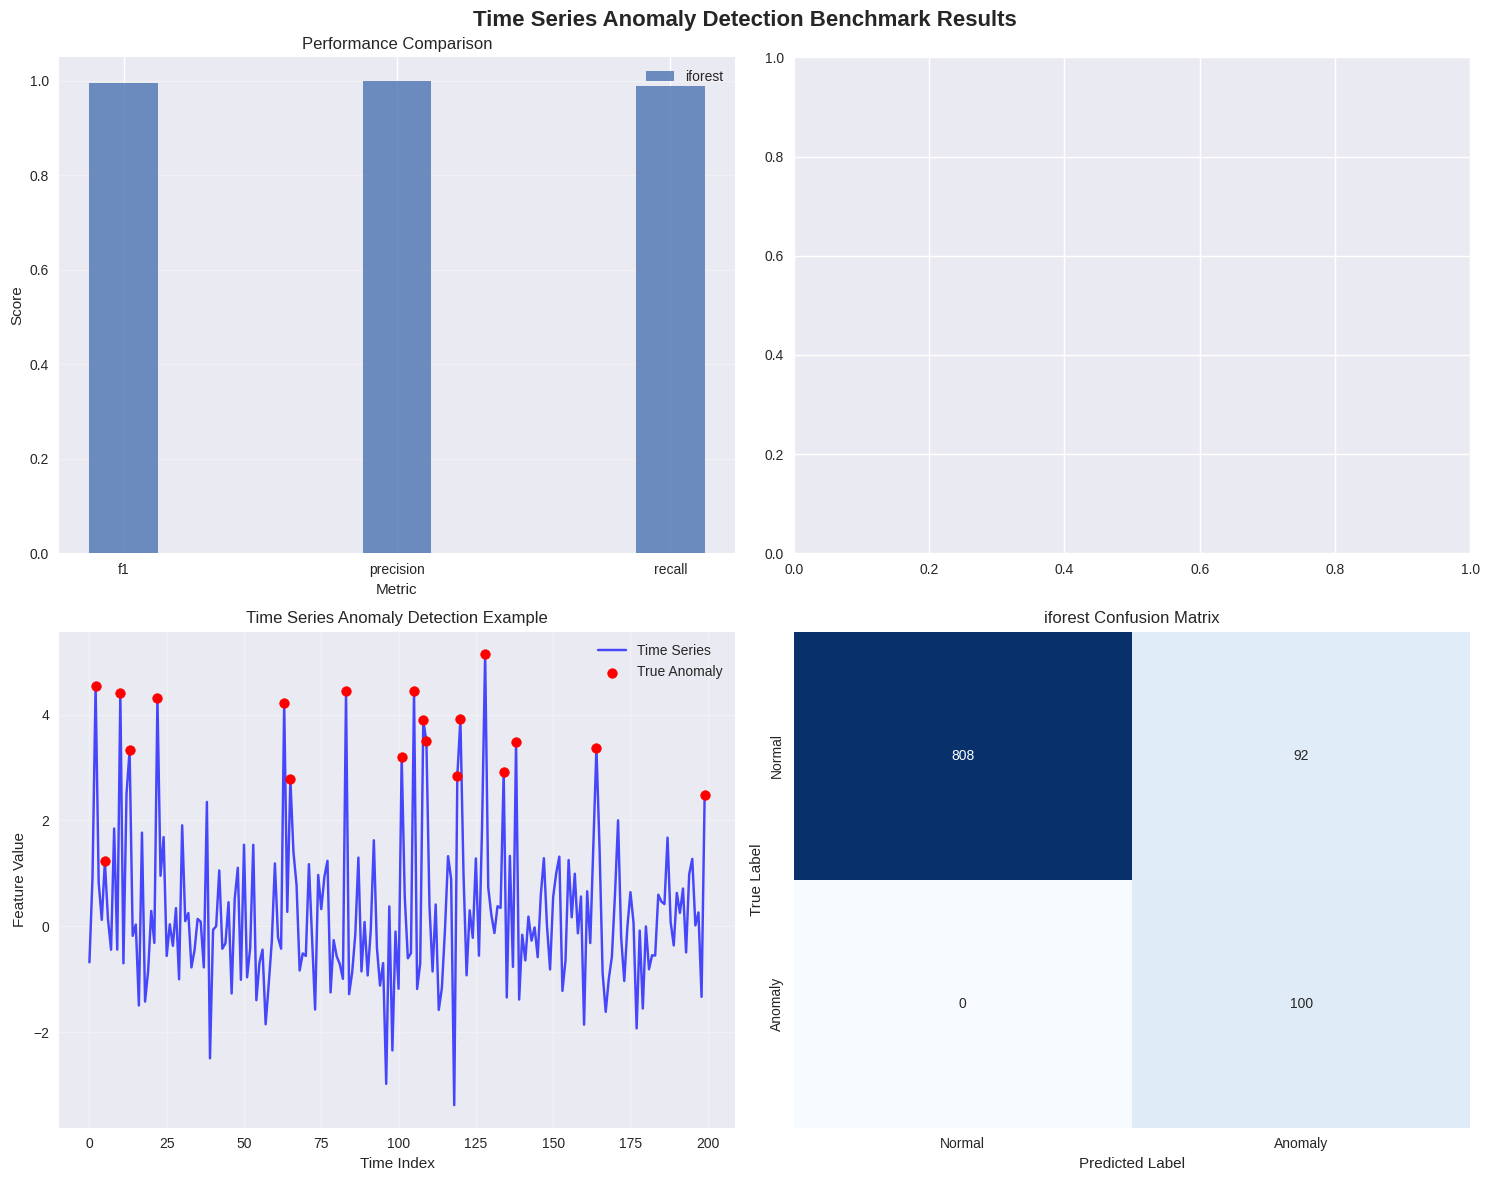

Visualization charts generated


In [10]:
# 可视化结果
if experiment_results and config['output']['generate_plots']:
    print("\nGenerating visualization charts")
    
    # Set plot style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Time Series Anomaly Detection Benchmark Results', fontsize=16, fontweight='bold')
    
    # 1. Performance metrics bar chart
    ax1 = axes[0, 0]
    metrics_to_plot = ['f1', 'precision', 'recall']
    model_names = list(experiment_results.keys())
    
    x = np.arange(len(metrics_to_plot))
    width = 0.35 if len(model_names) == 2 else 0.25
    
    for i, model_name in enumerate(model_names):
        values = []
        for metric in metrics_to_plot:
            value = experiment_results[model_name].get(metric, 0)
            if isinstance(value, float) and not np.isnan(value):
                values.append(value)
            else:
                values.append(0)
        
        ax1.bar(x + i * width, values, width, label=model_name, alpha=0.8)
    
    ax1.set_xlabel('Metric')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Comparison')
    ax1.set_xticks(x + width * (len(model_names) - 1) / 2)
    ax1.set_xticklabels(metrics_to_plot)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Anomaly score distribution (example for first model)
   
    
    # 3. Time series anomaly detection example (first 200 points)
    ax3 = axes[1, 0]
    n_points = min(200, len(test_labels))
    time_indices = np.arange(n_points)
    
    # Show data for the first feature
    ax3.plot(time_indices, test_data[:n_points, 0], 'b-', alpha=0.7, label='Time Series')
    
    # Mark anomaly points
    anomaly_indices = np.where(test_labels[:n_points] == 1)[0]
    if len(anomaly_indices) > 0:
        ax3.scatter(anomaly_indices, test_data[anomaly_indices, 0], 
                   color='red', s=50, label='True Anomaly', zorder=5)
    
    ax3.set_xlabel('Time Index')
    ax3.set_ylabel('Feature Value')
    ax3.set_title('Time Series Anomaly Detection Example')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. Confusion matrix (for best model)
    if best_model:
        from sklearn.metrics import confusion_matrix
        import itertools
        
        ax4 = axes[1, 1]
        best_results = experiment_results[best_model]
        
        # Get best model predictions (binarized)
        best_model_obj = model_objects[best_model]
        if best_model == 'iforest':
            best_pred = best_model_obj.predict(test_data)
        elif best_model == 'lstm_ae':
            best_pred = (best_model_obj.predict(test_data, metadata) > np.percentile(best_model_obj.predict(train_data, metadata), 90)).astype(int)
        else:
            best_pred = np.zeros_like(test_labels)
        
        cm = confusion_matrix(test_labels, best_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax4)
        ax4.set_xlabel('Predicted Label')
        ax4.set_ylabel('True Label')
        ax4.set_title(f'{best_model} Confusion Matrix')
        ax4.xaxis.set_ticklabels(['Normal', 'Anomaly'])
        ax4.yaxis.set_ticklabels(['Normal', 'Anomaly'])
    plt.tight_layout()
    plt.show()
    
    print("Visualization charts generated")

## 5. 结果保存与报告生成

In [11]:
# 保存实验结果
if config['output']['save_results'] and experiment_results:
    print("\nSaving experiment results")
    
    # Create results directory
    results_dir = project_root / config['output']['results_dir']
    results_dir.mkdir(exist_ok=True)
    
    # Generate timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    experiment_name = config['experiment']['name']
    
    # 保存详细结果，修正元数据字段
    train_size = train_data.shape[0] if 'train_data' in locals() else None
    test_size = test_data.shape[0] if 'test_data' in locals() else None
    anomaly_rate = (np.sum(test_labels) / len(test_labels)) if 'test_labels' in locals() else None
    detailed_results = {
        'experiment_info': config['experiment'],
        'data_info': {
            'dataset': getattr(metadata, 'dataset_name', 'unknown'),
            'n_features': getattr(metadata, 'feature_dim', None),
            'train_size': train_size,
            'test_size': test_size,
            'anomaly_rate': anomaly_rate,
            'fault_type': getattr(metadata, 'fault_type', None)
        },
        'model_results': experiment_results,
        'config': config
    }
    
print("结果保存功能待细化")

    # 保存为YAML文件
    # results_file = results_dir / f"{experiment_name}_{timestamp}.yaml"
    # with open(results_file, 'w', encoding='utf-8') as f:
    #     yaml.dump(detailed_results, f, default_flow_style=False, allow_unicode=True)
    
    # print(f"Results saved to: {results_file}")
    
    # # 保存对比表格为CSV
    # if 'comparison_df' in locals():
    #     csv_file = results_dir / f"{experiment_name}_{timestamp}_comparison.csv"
    #     comparison_df.to_csv(csv_file, index=False)
    #     print(f"Comparison table saved to: {csv_file}")
    
    # # 保存可视化图表
    # if config['output']['generate_plots']:
    #     plot_file = results_dir / f"{experiment_name}_{timestamp}_plots.png"
    #     if 'fig' in locals():
    #         fig.savefig(plot_file, dpi=300, bbox_inches='tight')
    #         print(f"Plot saved to: {plot_file}")




Saving experiment results
结果保存功能待细化


## 6. 实验总结与建议

In [12]:
# 生成实验总结报告
print("\n实验总结报告")
print("=" * 80)

print(f"实验名称: {config['experiment']['name']}")
print(f"数据集: {metadata.dataset_name}")

print(f"评估指标: {', '.join(config['evaluation']['metrics'])}")

if experiment_results:
    print(f"\n主要发现:")
    
    # 分析各模型性能
    for model_name, results in experiment_results.items():
        f1_score = results.get('f1', 0)
        precision = results.get('precision', 0)
        recall = results.get('recall', 0)
        
        print(f" - {model_name}: F1={f1_score:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

        


print("\n基准测试实验完成")


实验总结报告
实验名称: benchmark_experiment_01
数据集: simulated_data
评估指标: f1, precision, recall, auc, f1_point_adjusted

主要发现:
 - iforest: F1=0.9950, Precision=1.0000, Recall=0.9900

基准测试实验完成


In [13]:
# 批量实验示例（可选运行）
def run_batch_experiments(base_config, param_grid):
    """
    运行批量实验进行参数扫描
    
    Args:
        base_config: 基础配置
        param_grid: 参数网格
    """
    batch_results = []
    
    for i, params in enumerate(param_grid):
        print(f"\n 批量实验 {i+1}/{len(param_grid)}")
        
        # 更新配置
        current_config = base_config.copy()
        for key, value in params.items():
            # 支持嵌套键如 'models.iforest.n_estimators'
            keys = key.split('.')
            target = current_config
            for k in keys[:-1]:
                target = target[k]
            target[keys[-1]] = value
        
        # 运行实验（这里简化为示例）
        print(f"   参数: {params}")
        
        # TODO: 在这里添加完整的实验流程
        # 这需要重构上面的代码为函数形式
        
        batch_results.append({
            'params': params,
            'results': {}  # 实际结果
        })
    
    return batch_results

# 示例参数网格（实际使用时取消注释）
# param_grid = [
#     {'models.iforest.n_estimators': 50, 'models.iforest.contamination': 0.05},
#     {'models.iforest.n_estimators': 100, 'models.iforest.contamination': 0.1},
#     {'models.iforest.n_estimators': 200, 'models.iforest.contamination': 0.15},
# ]

# # 运行批量实验
# batch_results = run_batch_experiments(config, param_grid)

print("批量实验功能待定义")

批量实验功能待定义
